# Model Preparation: YouTube Viewer Data

## Goal: To practice data munging/cleaning, exploration, and feature engineering

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')

In [2]:
#Pull data from PostgreSQL database

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'youtube'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

youtube_df = pd.read_sql_query('select * from youtube',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

## Exploratory Data Analysis (EDA): Data Cleaning

In [3]:
youtube_df.info

<bound method DataFrame.info of          Rank Grade                Channel name Video Uploads Subscribers  \
0         1st  A++                       Zee TV         82757    18752951   
1         2nd  A++                     T-Series         12661    61196302   
2         3rd  A++   Cocomelon - Nursery Rhymes           373    19238251   
3         4th  A++                    SET India         27323    31180559   
4         5th  A++                          WWE         36756    32852346   
...       ...   ...                         ...           ...         ...   
4995  4,996th   B+               Uras Benlioğlu           706     2072942   
4996  4,997th   B+            HI-TECH MUSIC LTD           797     1055091   
4997  4,998th   B+                  Mastersaint           110     3265735   
4998  4,999th   B+               Bruce McIntosh          3475       32990   
4999  5,000th   B+                    SehatAQUA           254       21172   

      Video views  
0     20869786591  
1  

In [4]:
youtube_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Rank           5000 non-null   object
 1   Grade          5000 non-null   object
 2   Channel name   5000 non-null   object
 3   Video Uploads  5000 non-null   object
 4   Subscribers    5000 non-null   object
 5   Video views    5000 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 234.5+ KB


#### Observation: This dataset contains 5,000 observations and 6 columns. It appears that only the Video views field is an integer and that the rest are objects (which means that they are strings).

In [5]:
# print first rows of the data frame
youtube_df.head()

,Rank,Grade,Channel name,Video Uploads,Subscribers,Video views
0,1st,A++,Zee TV,82757,18752951,20869786591
1,2nd,A++,T-Series,12661,61196302,47548839843
2,3rd,A++,Cocomelon - Nursery Rhymes,373,19238251,9793305082
3,4th,A++,SET India,27323,31180559,22675948293
4,5th,A++,WWE,36756,32852346,26273668433


#### Observation: both Video Uploads and Subscribers are integer values even though listed as 'object' data type. Why? Because the columns include both missing values and observations stored in the database as --.

In [7]:
# Select the rows where values of the Video Uploads and Subscribers columns are equal to --:

youtube_df[(youtube_df["Video Uploads"].str.strip() == "--") | (youtube_df["Subscribers"].str.strip() == '--')]
                                                                

,Rank,Grade,Channel name,Video Uploads,Subscribers,Video views
17,18th,A+,Vlad and Nikita,53,--,1428274554
108,109th,A,BIGFUN,373,--,941376171
115,116th,A,Bee Kids Games - Children TV,740,--,414535723
142,143rd,A,ChiChi TV Siêu Nhân,421,--,2600394871
143,144th,A,MusicTalentNow,1487,--,3252752212
...,...,...,...,...,...,...
4941,"4,942nd",B+,GMTV,183,--,127080542
4948,"4,949th",B+,Keivon ToysReview,468,--,481568513
4956,"4,957th",B+,CLICKNEWS,2661,--,139940815
4961,"4,962nd",B+,ONE Championship,905,--,109836654


#### Observation: there are a total of 390 rows in our dataset that include -- as the value for either the Video Uploads or Subscribers columns.

### Categorical or Continuous?

* Continuous variables in the dataset are 'Video Uploads', 'Subscribers' and 'Video views', while the categorical variables are 'Grade', 'Rank', and 'Channel name'. 

* Idea: if smaller numbers, then likely to be categorical. Recommend using .unique

In [8]:
youtube_df.nunique()

Rank             5000
Grade               6
Channel name     4993
Video Uploads    2286
Subscribers      4612
Video views      5000
dtype: int64

#### Observation: we can see that the Grade column has only 6 distinct values, so it's safe to classify this as a categorical variable. But Channel name has nearly 5,000 unique values—how can we be sure it's categorical?

Here, we must simply think logically about our data. Since Channel name stores the name of the YouTube channel, we can think of each channel as a unique category. The number possibilities this value can take is limited to the number of YouTube channels, so it's a categorical variable.

What about the 'Rank' column? Since this contains the rank of each channel, it can be considered as either an ordinal categorical variable or as an interval continuous variable. The variable type we choose will depend on the task at hand and likely some experimentation on the data to decide which is more helpful. 

### Feature Engineering
Create New Feature
* The most watched channels, where the video views are higher than 1 billion.
* The moderately watched channels, where the video views are lower than 1 billion and higher than 100 million.
* The least watched channels, where the video views are lower than 100 million.

Transform a continuous variable into an ordinal, categorical variable: views_group

In [9]:
# Method returns group numbers 
    # given video views
    
def categorize_video_views(views_num):
    if views_num >= 1000000000:  #if greater than 1 billion views
        return 1
    elif views_num >= 100000000:  #if greater than 10 million views 
        return 2
    else:
        return 3

# we use Pandas' .apply() method by calling the function above.
youtube_df['views_group'] = youtube_df['Video views'].apply(categorize_video_views)

# let's see how many observations we have in each group
print(youtube_df.groupby("views_group")["Video views"].count())

views_group
1    1399
2    2846
3     755
Name: Video views, dtype: int64


### EDA: Data Cleaning Missing Data
Pandas provides us the .nunique() function on DataFrames to get the count of the unique values in each column. 

To list all unique values in each column of our DataFrame, we can call the Pandas .unique() function. 

In [10]:
youtube_df.isnull()

,Rank,Grade,Channel name,Video Uploads,Subscribers,Video views,views_group
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
4995,False,False,False,False,False,False,False
4996,False,False,False,False,False,False,False
4997,False,False,False,False,False,False,False
4998,False,False,False,False,False,False,False


In [11]:
youtube_df.nunique()

Rank             5000
Grade               6
Channel name     4993
Video Uploads    2286
Subscribers      4612
Video views      5000
views_group         3
dtype: int64

In [13]:
#Identify unique values per column by creating a loop 

for column_name in youtube_df.columns:
    print("Unique values in column {} are: {}".format(column_name, youtube_df[column_name].unique()))

Unique values in column Rank are: ['1st' '2nd' '3rd' ... '4,998th' '4,999th' '5,000th']
Unique values in column Grade are: ['A++ ' 'A+ ' 'A ' '\xa0 ' 'A- ' 'B+ ']
Unique values in column Channel name are: ['Zee TV' 'T-Series' 'Cocomelon - Nursery Rhymes' ... 'Mastersaint'
 'Bruce McIntosh' 'SehatAQUA']
Unique values in column Video Uploads are: ['82757' '12661' '373' ... '1735' '706' '3475']
Unique values in column Subscribers are: ['18752951' '61196302' '19238251' ... '3265735' '32990' '21172']
Unique values in column Video views are: [20869786591 47548839843  9793305082 ...   311758426    14563764
    73312511]
Unique values in column views_group are: [1 2 3]


#### Observation: Video Uploads and Subscribers variables appear to be numeric. So, let's convert these fields to numeric—the values that we can't convert to float will likely be the problematic values.

In [14]:
# print all values that cannot be converted to float
for column_name in ["Video Uploads", "Subscribers"]:
    print("These are the problematic values for the variable: {}".format(column_name))
    for value in youtube_df[column_name]:
        try:
            float(value)
        except:
            print(value)

These are the problematic values for the variable: Video Uploads
--
--
--
--
--
--
These are the problematic values for the variable: Subscribers
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
-- 
--

#### Observation:
the missing values in these two columns appeared to be stored as --. Note that there may be some trailing spaces around --.

Let's convert these problem records to empty strings and then convert the variables to float:

In [68]:
# replace "--" values to empty strings

youtube_df["Video Uploads"] = youtube_df["Video Uploads"].apply(str.strip).replace("--", np.nan)
youtube_df["Video Uploads"] = pd.to_numeric(youtube_df["Video Uploads"], downcast="float")

youtube_df["Subscribers"] = youtube_df["Subscribers"].apply(str.strip).replace("--", np.nan)
youtube_df["Subscribers"] = pd.to_numeric(youtube_df["Subscribers"], downcast="float")

In [20]:
youtube_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rank           5000 non-null   object 
 1   Grade          5000 non-null   object 
 2   Channel name   5000 non-null   object 
 3   Video Uploads  4994 non-null   float32
 4   Subscribers    4613 non-null   float32
 5   Video views    5000 non-null   int64  
 6   views_group    5000 non-null   int64  
dtypes: float32(2), int64(2), object(3)
memory usage: 234.5+ KB


In [21]:
youtube_df.isnull()

,Rank,Grade,Channel name,Video Uploads,Subscribers,Video views,views_group
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
4995,False,False,False,False,False,False,False
4996,False,False,False,False,False,False,False
4997,False,False,False,False,False,False,False
4998,False,False,False,False,False,False,False


In [22]:
youtube_df.isnull().sum()*100/youtube_df.isnull().count()

Rank             0.00
Grade            0.00
Channel name     0.00
Video Uploads    0.12
Subscribers      7.74
Video views      0.00
views_group      0.00
dtype: float64

In [23]:
youtube_df.Grade.value_counts()

B+      2956
A-      1024
A        963
A+        41
A++       10
           6
Name: Grade, dtype: int64

#### Observation:
Check the last row. It appears that we have empty string values which include trailing spaces. These extra spaces mean that they don't show up when we count the missing values! Just because a record looks missing to you, doesn't mean it is to Pandas!

Let's convert these records to np.nan and then check whether our changes took effect:

In [ ]:
youtube_df.Grade = youtube_df.Grade.apply(str.strip).replace("", np.nan)

youtube_df.Grade.unique()

In [24]:
# Use fillna method
youtube_df["Video Uploads"].fillna(youtube_df["Video Uploads"].mean(), inplace=True)
youtube_df["Subscribers"].fillna(youtube_df["Subscribers"].mean(), inplace=True)

# Be careful with inplace=True. It works in this case, but sometimes it is safer to use this:
# youtube_df["Video Uploads"] = youtube_df["Video Uploads"].fillna(youtube_df["Video Uploads"].mean())
# youtube_df["Subscribers"] = youtube_df["Subscribers"].fillna(youtube_df["Subscribers"].mean())
# (See the Assignment example solution for more detail on this issue)

In [25]:
youtube_df.isnull().sum()*100/youtube_df.count()

Rank             0.0
Grade            0.0
Channel name     0.0
Video Uploads    0.0
Subscribers      0.0
Video views      0.0
views_group      0.0
dtype: float64

In [26]:
# fill in missing values in Category with the the value of the next highest-ranked channel's category

grade_list = youtube_df.Grade

for i in range(0, len(youtube_df.Grade)):
    if pd.isnull(youtube_df.Grade[i]):
        youtube_df.Grade[i] = youtube_df.Grade[i-1]
        
youtube_df["Grade"].unique()

array(['A++ ', 'A+ ', 'A ', '\xa0 ', 'A- ', 'B+ '], dtype=object)

### EDA: Detect Outliers

<function matplotlib.pyplot.show(*args, **kw)>

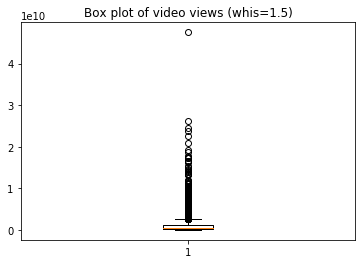

In [29]:
import matplotlib.pyplot as plt

plt.boxplot(youtube_df["Video views"])
plt.title("Box plot of video views (whis=1.5)")
plt.show

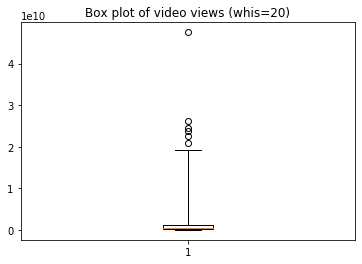

In [30]:
plt.boxplot(youtube_df["Video views"], whis=20)
plt.title("Box plot of video views (whis=20)")
plt.show()

#### Note: 
Histograms depict the distribution of the variables. Values that lie at extreme ends of the graph are potential outliers. Let's draw the histogram of the Video views variable:

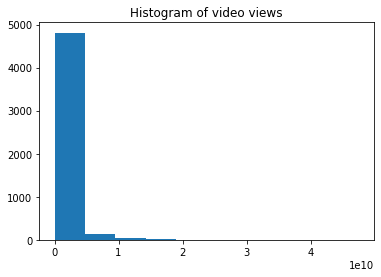

In [31]:
plt.hist(youtube_df["Video views"])
plt.title("Histogram of video views")
plt.show()

#### Statistical methods to detect outliers
Z-scores
One statistic used to detect the outliers in a variable is the Z-score. To calculate Z-scores, we will first scale the variable so that its mean is 0 and its standard deviation is 1. Then we can measure how far a value is far away from the mean (0) in terms of standard deviations (1). The bigger the Z-score of a value, the farther it is from the mean, and the more likely it is an outlier. However, we still need to set a threshold for what Z-score constitutes an outlier.

Let's calculate the Z-score's of the Video views variable using SciPy's zscore() function and determine outliers by setting the threshold to 1, 2, 3, and 4:

In [32]:
from scipy.stats import zscore

z_scores = zscore(youtube_df["Video views"])
for threshold in range(1,5):
    print("The score threshold is: {}".format(threshold))
    print("The indices of the outliers:")
    print(np.where(z_scores > threshold))
    print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))

The score threshold is: 1
The indices of the outliers:
(array([   0,    1,    2,    3,    4,    5,    6,    7,    8,   10,   11,
         13,   14,   15,   16,   18,   19,   21,   22,   25,   26,   27,
         35,   37,   38,   39,   40,   41,   42,   43,   44,   46,   47,
         48,   49,   50,   51,   52,   53,   54,   57,   58,   59,   61,
         62,   63,   64,   66,   67,   68,   70,   72,   74,   75,   77,
         78,   81,   82,   83,   84,   85,   87,   88,   91,   93,   95,
         98,   99,  105,  106,  111,  112,  113,  114,  116,  120,  121,
        122,  123,  125,  126,  127,  130,  131,  135,  137,  138,  143,
        145,  146,  147,  149,  151,  154,  155,  158,  165,  167,  170,
        171,  172,  174,  176,  182,  184,  187,  193,  198,  200,  201,
        208,  210,  212,  218,  224,  227,  228,  229,  241,  242,  244,
        245,  248,  249,  254,  256,  257,  260,  261,  264,  265,  266,
        268,  269,  270,  271,  273,  277,  282,  283,  284,  287,  

#### Tukey's method
This method is also known as the Interquartile Range (IQR) method and we saw this method in action when we talked about box plots.

As mentioned earlier, the IQR is the range between the 1st and the 3rd quartiles. This method considers all values that are outside the threshold of 1.5 times the IQR as outliers. However, we can change this threshold to other values.

Using 1, 1.5, 2 ... 4.5 as the threshold values, let's find out the number of outliers in the Video views variable using Tukey's method:

In [33]:
# NumPy's percentile() method returns the 
# values of the given percentiles. In our case,
# we give 75 and 25 as parameters which corresponds 
# to the third and the first quartile.
    
    #Create a function that represents 'iqr'
q75, q25 = np.percentile(youtube_df["Video views"], [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((youtube_df["Video views"] > max_val) 
                      | (youtube_df["Video views"] < min_val))[0]))
    ))

The score threshold is: 1.0
Number of outliers is: 624
The score threshold is: 1.5
Number of outliers is: 475
The score threshold is: 2.0
Number of outliers is: 371
The score threshold is: 2.5
Number of outliers is: 296
The score threshold is: 3.0
Number of outliers is: 242
The score threshold is: 3.5
Number of outliers is: 209
The score threshold is: 4.0
Number of outliers is: 182
The score threshold is: 4.5
Number of outliers is: 151


#### Limiting the values of the outliers
The main problem with the outliers stems from their extreme magnitudes. If we can cap the values of the outliers, their effects on our analysis would be limited. One common way of limiting the outlier values is called winsorization. Winsorization can be applied in one-way or two-way techniques. In one-way winsorization, we either limit the lowest end of the value distribution or the highest end. In two-way winsorization, we set limits on both the lowest end and the highest end.

The idea in winsorization is to set the values of the extreme points to the value of a specified percentile. For example, we may set the values of the highest end of the distribution to the value of the 95th percentile. Similarly, we can set the values of the lowest end to the value of the 5th percentile.

We can winsorize a variable using SciPy's winsorize() method. We give a tuple of values as a parameter to this method where the 1st element of the tuple is the lowest percentile and the 2nd element is the highest percentile in the two-way winsorization. If we want to apply one-way percentile, we can set the corresponding element in this tuple to zero (0). Now, let's winsorize the Video views variable:

In [34]:
from scipy.stats.mstats import winsorize

# We apply one-way winsorization to the highest end
# of the value distribution. As we have a lot of extreme
# values, we set the values of the outliers to the 
# value of the 90th percentile. 
winsorized_views = winsorize(youtube_df["Video views"], (0, 0.10))

winsorized_views

masked_array(data=[2468241402, 2468241402, 2468241402, ...,  311758426,
                     14563764,   73312511],
             mask=False,
       fill_value=999999)

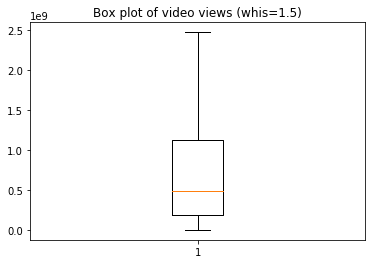

In [35]:
plt.boxplot(winsorized_views)
plt.title("Box plot of video views (whis=1.5)")
plt.show()

#### Transforming outliers
Another common way of dealing with outliers is to transform the variable. Transformation not only helps us with outliers but also with variables that are not normally distributed. When transforming the variable, we usually apply monotonic transformations. These are transformations that don't change the relative ordering of the values in a variable. Log transformations and square root transformations are 2 common monotonic transformations in data science.

To see the effect of a log transformation on the Video views variable, let's sketch the histogram of the original variable and the log transformed version:



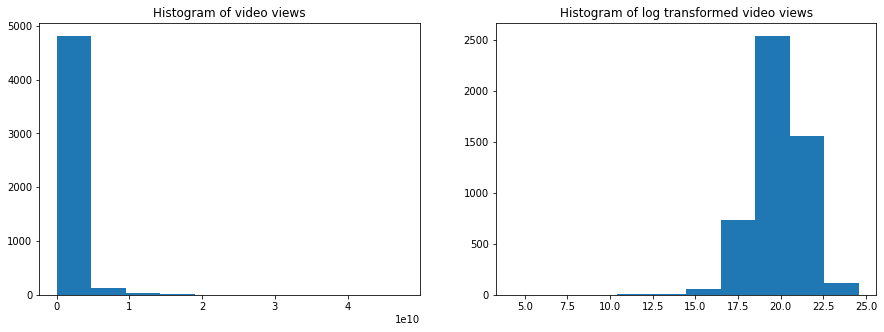

In [36]:
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.hist(youtube_df["Video views"])
plt.title("Histogram of video views")

plt.subplot(1,2,2)
plt.hist(np.log(youtube_df["Video views"]))
plt.title("Histogram of log transformed video views")
plt.show()

#### Note: 
As we can see, the log transformed variable more closely matches a normal distribution. This will help us apply statistical techniques for future analysis. But for now, let's look at the box plots of the original variable and its log transformed variant to see whether log transformation has an effect on the outliers:

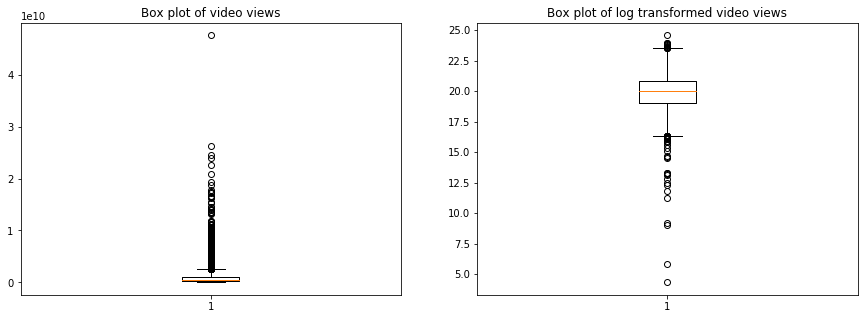

In [37]:
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.boxplot(youtube_df["Video views"])
plt.title("Box plot of video views")

plt.subplot(1,2,2)
plt.boxplot(np.log(youtube_df["Video views"]))
plt.title("Box plot of log transformed video views")
plt.show()

In [38]:
#Apply Tukey's method to see if number of outliers reduced.
# now we take the log of the video views and calculate
# the quartiles accordingly.
q75, q25 = np.percentile(np.log(youtube_df["Video views"]), [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((np.log(youtube_df["Video views"]) > max_val) 
                      | (np.log(youtube_df["Video views"]) < min_val))[0]))
    ))

The score threshold is: 1.0
Number of outliers is: 326
The score threshold is: 1.5
Number of outliers is: 58
The score threshold is: 2.0
Number of outliers is: 19
The score threshold is: 2.5
Number of outliers is: 14
The score threshold is: 3.0
Number of outliers is: 13
The score threshold is: 3.5
Number of outliers is: 8
The score threshold is: 4.0
Number of outliers is: 6
The score threshold is: 4.5
Number of outliers is: 4


In [ ]:
# we're dealing with the missing values

youtube_df["Video Uploads"] = youtube_df["Video Uploads"].apply(str.strip).replace("--", np.nan)
youtube_df["Video Uploads"] = pd.to_numeric(youtube_df["Video Uploads"], downcast="float")

youtube_df["Subscribers"] = youtube_df["Subscribers"].apply(str.strip).replace("--", np.nan)
youtube_df["Subscribers"] = pd.to_numeric(youtube_df["Subscribers"], downcast="float")

youtube_df.Grade = youtube_df.Grade.apply(str.strip).replace("", np.nan)

In [48]:
# we're dealing with the missing values

#youtube_df["Video Uploads"] = youtube_df["Video Uploads"].apply(str.strip).replace("--", np.nan)
#youtube_df["Video Uploads"] = pd.to_numeric(youtube_df["Video Uploads"], downcast="float")

#youtube_df["Subscribers"] = youtube_df["Subscribers"].apply(str.strip).replace("--", np.nan)
#youtube_df["Subscribers"] = pd.to_numeric(youtube_df["Subscribers"], downcast="float")

#youtube_df.Grade = youtube_df.Grade.apply(str.strip).replace("", np.nan)

    #Fill in the missing values with the mean of features
youtube_df["Video Uploads"].fillna(youtube_df["Video Uploads"].mean(), inplace=True)
youtube_df["Subscribers"].fillna(youtube_df["Subscribers"].mean(), inplace=True)

#### Winsorize

In [47]:
# We apply one-way winsorization to the highest end of the value distribution. 
    # Since we have a lot of extreme values, we set the values of the outliers to the value of the 90th percentile. 

youtube_df["winsorized_uploads"] = winsorize(youtube_df["Video Uploads"], (0, 0.10))
youtube_df["winsorized_subscribers"] = winsorize(youtube_df["Subscribers"], (0, 0.10))
youtube_df["winsorized_views"] = winsorize(youtube_df["Video views"], (0, 0.10))

#Check winsorized_views
print(youtube_df['winsorized_views'])

for i in range(0, len(youtube_df.Grade)):
    if pd.isnull(youtube_df.Grade[i]):
        youtube_df.Grade[i] = youtube_df.Grade[i-1]
#Check winsorized_views
print(youtube_df)

0       2468241402
1       2468241402
2       2468241402
3       2468241402
4       2468241402
           ...    
4995     441202795
4996     377331722
4997     311758426
4998      14563764
4999      73312511
Name: winsorized_views, Length: 5000, dtype: int64
         Rank Grade                Channel name  Video Uploads  Subscribers  \
0         1st  A++                       Zee TV        82757.0   18752952.0   
1         2nd  A++                     T-Series        12661.0   61196304.0   
2         3rd  A++   Cocomelon - Nursery Rhymes          373.0   19238252.0   
3         4th  A++                    SET India        27323.0   31180560.0   
4         5th  A++                          WWE        36756.0   32852346.0   
...       ...   ...                         ...            ...          ...   
4995  4,996th   B+               Uras Benlioğlu          706.0    2072942.0   
4996  4,997th   B+            HI-TECH MUSIC LTD          797.0    1055091.0   
4997  4,998th   B+           


## Exploratory Data Analysis (EDA): Data Exploration 
### Univariate Analysis

In [40]:
# get univariate statistics
youtube_df.describe()

,Video Uploads,Subscribers,Video views,views_group
count,5000.000000,5000.00,5.000000e+03,5000.000000
mean,3859.466797,2620021.50,1.071449e+09,1.871200
std,17075.607422,3771402.25,2.003844e+09,0.643656
min,1.000000,301.00,7.500000e+01,1.000000
25%,141.000000,666802.50,1.862329e+08,1.000000
50%,445.000000,1544402.00,4.820548e+08,2.000000
75%,1511.500000,2723181.50,1.124368e+09,2.000000
max,422326.000000,65995312.00,4.754884e+10,3.000000


### NOTE: Since we want to include descriptive statistics for STRING based variables, we can use include=['O'] to see just the text variables, or `include='all' to see all variables:

In [49]:
youtube_df.describe(include=['O'])

,Rank,Grade,Channel name
count,5000,5000,5000
unique,5000,6,4993
top,663rd,B+,Webs & Tiaras - Toy Monster…
freq,1,2956,2


In [50]:
#Describe ALL variables
youtube_df.describe(include='all')

,Rank,Grade,Channel name,Video Uploads,Subscribers,Video views,views_group,winsorized_uploads,winsorized_subscribers,winsorized_views
count,5000,5000,5000,5000.000000,5000.00,5.000000e+03,5000.000000,5000.000000,5000.00,5.000000e+03
unique,5000,6,4993,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,663rd,B+,Webs & Tiaras - Toy Monster…,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,2956,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,3859.466797,2620021.50,1.071449e+09,1.871200,1288.413818,2081598.25,7.828476e+08
std,NaN,NaN,NaN,17075.607422,3771402.25,2.003844e+09,0.643656,1779.179321,1781480.25,7.754301e+08
min,NaN,NaN,NaN,1.000000,301.00,7.500000e+01,1.000000,1.000000,301.00,7.500000e+01
25%,NaN,NaN,NaN,141.000000,666802.50,1.862329e+08,1.000000,141.000000,666802.50,1.862329e+08
50%,NaN,NaN,NaN,445.000000,1544402.00,4.820548e+08,2.000000,445.000000,1544402.00,4.820548e+08
75%,NaN,NaN,NaN,1511.500000,2723181.50,1.124368e+09,2.000000,1511.500000,2723181.50,1.124368e+09


### Univariate visualization of continuous variables

Text(0.5, 1.0, 'histogram of video views (winsorized)')

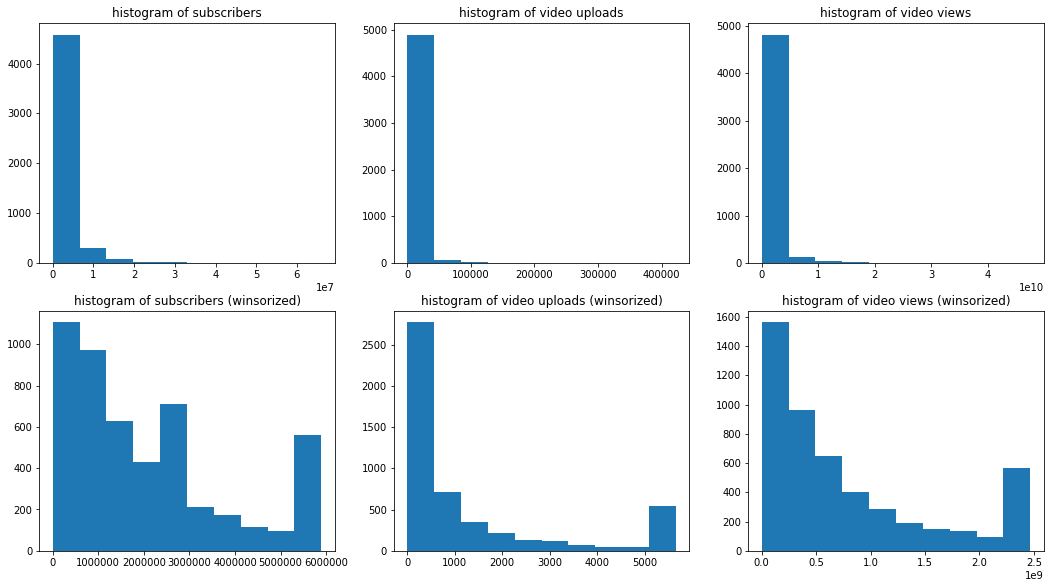

In [51]:
plt.figure(figsize=(18,15))

# histograms of the original data
plt.subplot(3, 3, 1)
plt.hist(youtube_df["Subscribers"])
plt.title("histogram of subscribers")

plt.subplot(3, 3, 2)
plt.hist(youtube_df["Video Uploads"])
plt.title("histogram of video uploads")

plt.subplot(3, 3, 3)
plt.hist(youtube_df["Video views"])
plt.title("histogram of video views")

# histograms of the winsorized data
plt.subplot(3, 3, 4)
plt.hist(youtube_df["winsorized_subscribers"])
plt.title("histogram of subscribers (winsorized)")

plt.subplot(3, 3, 5)
plt.hist(youtube_df["winsorized_uploads"])
plt.title("histogram of video uploads (winsorized)")

plt.subplot(3, 3, 6)
plt.hist(youtube_df["winsorized_views"])
plt.title("histogram of video views (winsorized)")

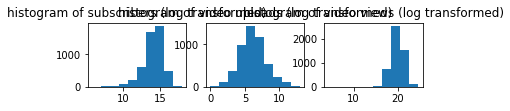

In [52]:
# histograms of the log transformed data
plt.subplot(3, 3, 7)
plt.hist(np.log(youtube_df["Subscribers"]))
plt.title("histogram of subscribers (log transformed)")

plt.subplot(3, 3, 8)
plt.hist(np.log(youtube_df["Video Uploads"]))
plt.title("histogram of video uploads (log transformed)")

plt.subplot(3, 3, 9)
plt.hist(np.log(youtube_df["Video views"]))
plt.title("histogram of video views (log transformed)")


plt.show()

### Univariate Visualization of Categorical Variables: Bar Chart
Visualizing categorical variables is slightly different than continuous variables because categorical variables take only limited number of values. One of the most commonly used chart types for categorical features is the bar chart. Below represents a bar chart that shows the number of observations for each value in the Grade variable:

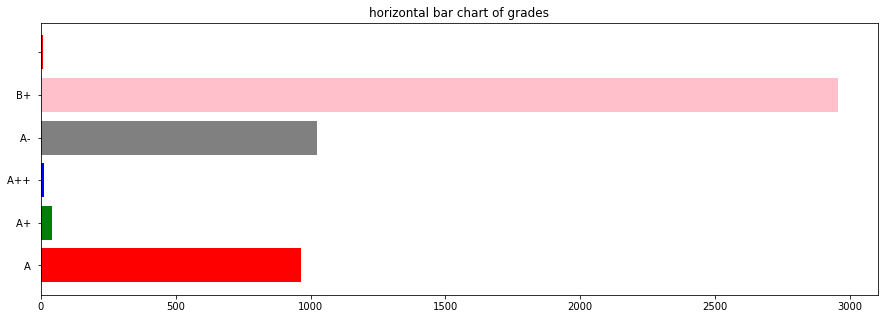

In [53]:
# bar chart of grades
plt.figure(figsize=(15,5))
plt.barh(youtube_df.groupby("Grade")["Grade"].count().index, 
        youtube_df.groupby("Grade")["Grade"].count(), 
        color=["red","green","blue","grey","pink"])
plt.title("horizontal bar chart of grades")

plt.show()

### Word Cloud

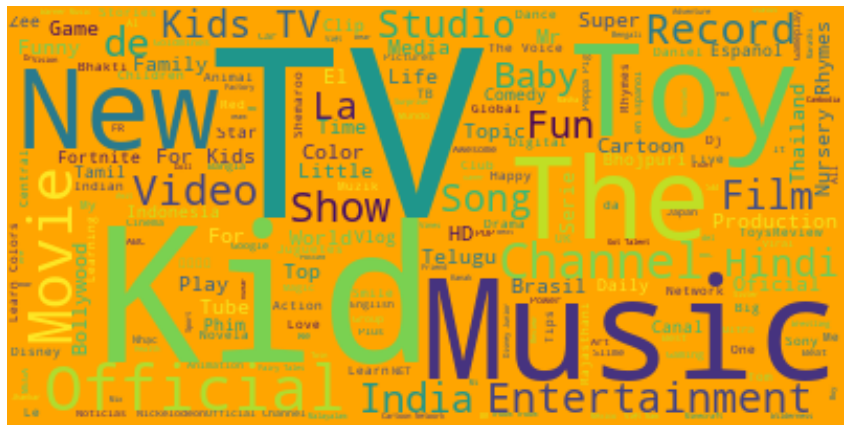

In [54]:
!pip install wordcloud

from wordcloud import WordCloud

# Generate a word cloud image
wordcloud = WordCloud(background_color="orange").generate(" ".join(youtube_df["Channel name"]))
plt.figure(figsize=(15,10))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.show()


### Observation: Kid, Toy, TV, Music, New, Movie, Official, Channel, etc. This gives signs our dataset might include a lot of channels for kids! 

## EDA: Multivariate Analysis
The "comovement" or covariance of the 2 variables over time reflects a common factor may affect these 2 variables, or 1 may affect the other ("interaction").

### Scatterplot
One of the most informative ways of looking at the relationship between 2 continuous variables is to draw a scatterplot (also known as a scattergram).

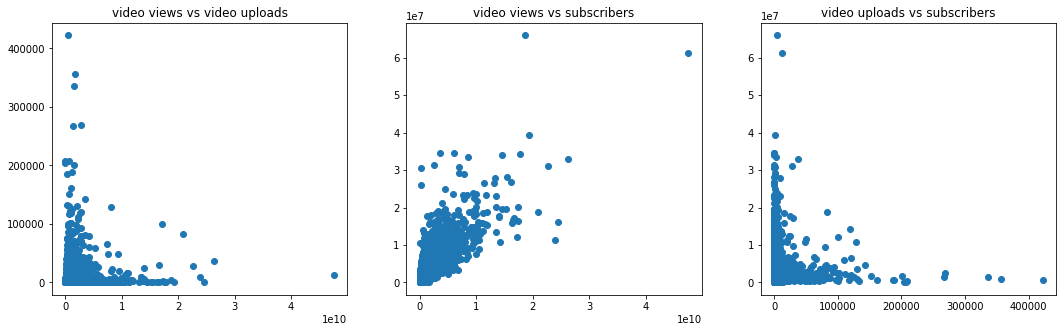

In [55]:
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.scatter(youtube_df["Video views"], youtube_df["Video Uploads"])
plt.title("video views vs video uploads")

plt.subplot(1,3,2)
plt.scatter(youtube_df["Video views"], youtube_df["Subscribers"])
plt.title("video views vs subscribers")

plt.subplot(1,3,3)
plt.scatter(youtube_df["Video Uploads"], youtube_df["Subscribers"])
plt.title("video uploads vs subscribers")

plt.show()

### Observation: In the second scatterplot, we see a positive relationship between the video views and the number of subscribers. Now, let's look at the relationship between different pairs of student test score

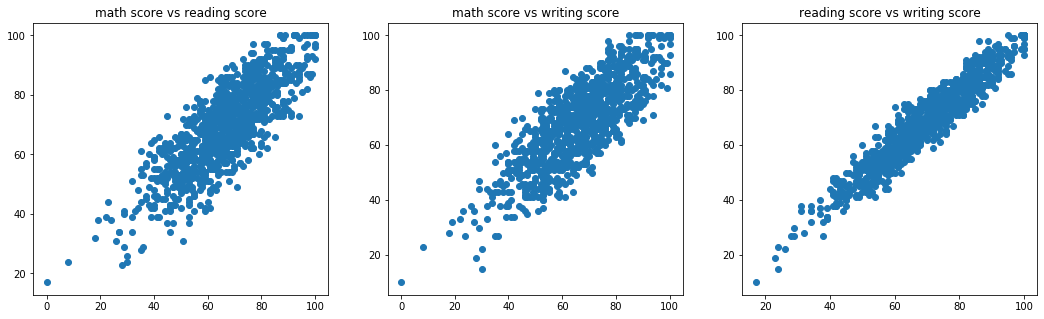

In [56]:
postgres_db = 'studentsperformance'

engine2 = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

student_df = pd.read_sql_query('select * from studentsperformance',con=engine2)

# no need for an open connection, 
# as we're only doing a single query
engine2.dispose()

plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.scatter(student_df["math score"], student_df["reading score"])
plt.title("math score vs reading score")

plt.subplot(1,3,2)
plt.scatter(student_df["math score"], student_df["writing score"])
plt.title("math score vs writing score")

plt.subplot(1,3,3)
plt.scatter(student_df["reading score"], student_df["writing score"])
plt.title("reading score vs writing score")

plt.show()

### Note: A note on outliers: Recall our checkpoint on outliers, we separately looked at extreme values for each variable. There is also another type of outlier, called a two-dimensional outlier, that represents unusual combinations of values. If you look at the scatterplots above carefully, you may notice some of those unusual value pairs. To deal with these, you can apply one of the techniques we explained in the outliers checkpoint.



### EDA: Correlation Coefficients
Another informative statistic that measures the comovements of two continuous variables is correlation coefficient. The correlation coefficient (r) is a numeric representation of the linear relationship between 2 continuous variables. Correlations range from -1 (a perfect negative relationship: as values in 1 variable go up, values in the other go down) to 0 (no relationship between the variables) to 1 (a perfect positive relationship: as values in 1 variable go up, values in the other go up as well).

Notice what we observed in the scatterplots is actually a visual representation of the correlations between variables. Using a number that is indexed between -1 and 1 adds a layer of precision and ease of interpretation across items.

Pandas provides us with the .corr() function to derive the correlation coefficients across all continuous features in a data frame. 

In [57]:
#Identify correlation for both data sets
youtube_df.corr()

,Video Uploads,Subscribers,Video views,views_group,winsorized_uploads,winsorized_subscribers,winsorized_views
Video Uploads,1.000000,0.011329,0.092423,-0.127316,0.473634,0.012593,0.134971
Subscribers,0.011329,1.000000,0.784449,-0.474272,0.082880,0.778046,0.626605
Video views,0.092423,0.784449,1.000000,-0.518276,0.219291,0.578920,0.700070
views_group,-0.127316,-0.474272,-0.518276,1.000000,-0.300533,-0.620166,-0.835457
winsorized_uploads,0.473634,0.082880,0.219291,-0.300533,1.000000,0.097699,0.307744
winsorized_subscribers,0.012593,0.778046,0.578920,-0.620166,0.097699,1.000000,0.743256
winsorized_views,0.134971,0.626605,0.700070,-0.835457,0.307744,0.743256,1.000000


In [58]:
# get correlation matrix for second data set
student_df.corr()

,math score,reading score,writing score
math score,1.000000,0.817580,0.802642
reading score,0.817580,1.000000,0.954598
writing score,0.802642,0.954598,1.000000


### Heatmaps

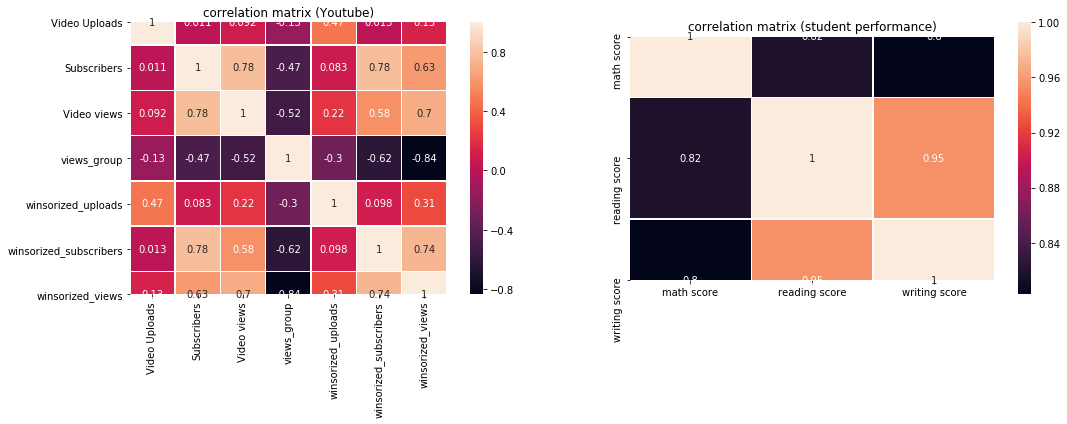

In [64]:
#Let's draw correlation matrices for both of our datasets as heatmaps using Seaborn:
# make the correlation matrices.

import seaborn as sns

corrmat_youtube = youtube_df.corr()

corrmat_student = student_df.corr()

# heatmaps are a great way to get 
# a quick visual read on a big correlation matrix.

plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
# draw the heatmap using seaborn.
sns.heatmap(corrmat_youtube, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix (Youtube)")

plt.subplot(1,2,2)
# draw the heatmap using seaborn.
sns.heatmap(corrmat_student, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix (student performance)")

plt.show()

# try to match the correlation numbers 
# to the scatterplots above to get a 
# sense of what each magnitude of 
# correlation can look like.


### Bivariate analysis of a continuous-categorical pair: Use .groupby
When we analyze a continuous and a categorical variable pair, we usually look at some metric of the continuous variable for each value of the categorical variable. If we observe different values across categories, then this implies the categorical variable has some important information regarding the continuous variable.

One way to look at this is to use the Pandas .groupby() function where we use the categorical variable as the grouping variable. After calling this function, we can call some aggregation function like .mean() or .count() to derive metrics for the continuous variable by group. Let's do this in the YouTube dataset using the Grade variable as the categorical variable

In [65]:
# Obtain averages by group 
    #Use .groupby
youtube_df.groupby("Grade").mean()

,Video Uploads,Subscribers,Video views,views_group,winsorized_uploads,winsorized_subscribers,winsorized_views
Grade,,,,,,,
A,5357.026855,4.936679e+06,2.361317e+09,1.447560,1670.775757,3400372.000,1.449714e+09
A+,16547.927734,1.150483e+07,6.053121e+09,1.146341,2729.877930,5061679.000,2.088445e+09
A++,37450.699219,2.228176e+07,2.119909e+10,1.000000,4673.700195,5590006.000,2.468241e+09
A-,4136.514648,2.784051e+06,1.041149e+09,1.769531,1319.476562,2329109.500,8.810693e+08
B+,2985.988281,1.621082e+06,5.265217e+08,2.055819,1116.423828,1514306.875,5.091491e+08
,3859.467041,1.449768e+06,9.912005e+07,2.666667,3859.467041,1449768.375,9.912005e+07


In [66]:
#call the .describe() function after .groupby()
youtube_df.groupby("Grade").describe()

Video Uploads                                                        \
              count          mean           std          min          25%   
Grade                                                                       
A             963.0   5357.026855  17880.017578     1.000000   183.000000   
A+             41.0  16547.927734  35245.734375    30.000000   230.000000   
A++            10.0  37450.699219  36001.503906   373.000000  9540.250000   
A-           1024.0   4136.514648  18377.935547     1.000000   135.000000   
B+           2956.0   2985.988281  15618.052734     1.000000   130.000000   
                6.0   3859.467041      0.000000  3859.467041  3859.467041   

                                                 Subscribers                \
                50%           75%            max       count          mean   
Grade                                                                        
A        604.000000   2698.000000  269065.000000       963.0  4.936676e+06   
A+      2204.000000  15672.000000  186194.000000        41.0  1.150483e+07   
A++    28783.000000  65144.250000  100147.000000        10.0  2.228176e+07   
A-       460.500000   1531.500000  355996.000000      1024.0  2.784049e+06   
B+       391.500000   1232.250000  422326.000000      2956.0  1.621077e+06   
        3859.467041   3859.467041    3859.467041         6.0  1.449768e+06   

       ... winsorized_subscribers             winsorized_views                \
       ...                    75%         max            count          mean   
Grade  ...                                                                     
A      ...             5895361.00  5895361.00            963.0  1.449714e+09   
A+     ...             5895361.00  5895361.00             41.0  2.088445e+09   
A++    ...             5895361.00  5895361.00             10.0  2.468241e+09   
A-     ...             3076369.25  5895361.00           1024.0  8.810693e+08   
B+     ...             2307278.00  5895361.00           2956.0  5.091491e+08   
       ...             2620007.75  2620007.75              6.0  9.912005e+07   

                                                                             \
                std           min           25%           50%           75%   
Grade                                                                         
A      8.901009e+08  3.500000e+02  6.180299e+08  1.469489e+09  2.468241e+09   
A+     7.595322e+08  2.246080e+08  2.250065e+09  2.468241e+09  2.468241e+09   
A++    0.000000e+00  2.468241e+09  2.468241e+09  2.468241e+09  2.468241e+09   
A-     7.640461e+08  8.496000e+03  2.573549e+08  6.296574e+08  1.315680e+09   
B+     5.403236e+08  7.500000e+01  1.349209e+08  3.326637e+08  6.749595e+08   
       8.325192e+07  9.745292e+06  3.333911e+07  8.563258e+07  1.655931e+08   

                     
                max  
Grade                
A      2.468241e+09  
A+     2.468241e+09  
A++    2.468241e+09  
A-     2.468241e+09  
B+     2.468241e+09  
       2.055553e+08  

[6 rows x 56 columns]

In [69]:
#Group by "views_group" for comparison
youtube_df.groupby("views_group").describe()

Video Uploads                                                 \
                    count         mean           std  min    25%     50%   
views_group                                                                
1                  1399.0  7281.750488  24139.052734  8.0  277.5  1051.0   
2                  2846.0  2952.773682  13689.017578  1.0  174.0   445.0   
3                   755.0   935.834167  10597.825195  1.0   32.0    99.0   

                              Subscribers               ...  \
                75%       max       count         mean  ...   
views_group                                             ...   
1            3519.5  355996.0      1399.0  5735684.000  ...   
2            1276.0  422326.0      2846.0  1579107.875  ...   
3             275.0  207072.0       755.0   770395.750  ...   

            winsorized_subscribers            winsorized_views                \
                               75%        max            count          mean   
views_group                                                                    
1                       5895361.00  5895361.0           1399.0  1.877772e+09   
2                       2136424.75  5895361.0           2846.0  4.388247e+08   
3                        888930.00  5895361.0            755.0  5.078113e+07   

                                                                     \
                      std           min           25%           50%   
views_group                                                           
1            5.460284e+08  1.000127e+09  1.335056e+09  1.909330e+09   
2            2.443432e+08  1.002010e+08  2.291098e+08  3.928020e+08   
3            2.669293e+07  7.500000e+01  2.677096e+07  5.135753e+07   

                                         
                      75%           max  
views_group                              
1            2.468241e+09  2.468241e+09  
2            6.190434e+08  9.998540e+08  
3            7.335438e+07  9.969853e+07  

[3 rows x 48 columns]

### Barplots

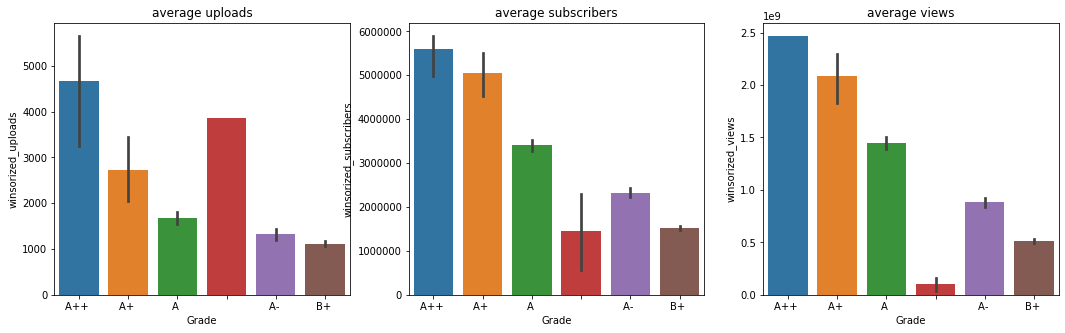

In [67]:
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
sns.barplot(youtube_df["Grade"], youtube_df["winsorized_uploads"])
plt.title("average uploads")

plt.subplot(1,3,2)
sns.barplot(youtube_df["Grade"], youtube_df["winsorized_subscribers"])
plt.title("average subscribers")

plt.subplot(1,3,3)
sns.barplot(youtube_df["Grade"], youtube_df["winsorized_views"])
plt.title("average views")

plt.show()

#### Obesrvations: 
Averages decrease as the grade lowers. However, visualizing differences is not a formal way of stating that there are significant differences across categories! For this, we need to use a proper statistical test, such as a t-test or ANOVA. So, let's use the t-test to learn whether the differences are statistically significant:

### T-Test

In [71]:
# Test whether group differences are significant.
import scipy.stats as stats  

grades = youtube_df["Grade"].unique()
grouped_df = youtube_df.groupby("Grade")
for var in ["winsorized_uploads", "winsorized_subscribers", "winsorized_views"]:
    print("------------------------------------------------")
    print("Comparisons for variable: {}".format(var))
    print("------------------------------------------------")
    for i in range(0, len(grades)):
        for j in range(i+1, len(grades)):
            print("t-test between groups {0} and {1}:".format(grades[i], grades[j]))
            print(stats.ttest_ind(
                youtube_df[youtube_df["Grade"]==grades[i]][var], 
                youtube_df[youtube_df["Grade"]==grades[j]][var]
            ))

------------------------------------------------
Comparisons for variable: winsorized_uploads
------------------------------------------------
t-test between groups A++  and A+ :
Ttest_indResult(statistic=2.3701079407396466, pvalue=0.021763510628877547)
t-test between groups A++  and A :
Ttest_indResult(statistic=4.643132232891612, pvalue=3.903060338886574e-06)
t-test between groups A++  and   :
Ttest_indResult(statistic=0.9489077693601997, pvalue=0.35876113695177647)
t-test between groups A++  and A- :
Ttest_indResult(statistic=5.849570829755956, pvalue=6.610430711945347e-09)
t-test between groups A++  and B+ :
Ttest_indResult(statistic=6.911020363549343, pvalue=5.867101369522697e-12)
t-test between groups A+  and A :
Ttest_indResult(statistic=3.2411767934575897, pvalue=0.0012295992679945175)
t-test between groups A+  and   :
Ttest_indResult(statistic=-1.1523778132453713, pvalue=0.2552510918894961)
t-test between groups A+  and A- :
Ttest_indResult(statistic=4.847071421048167, pvalue=

#### Some groups are statisically significant across some grades and not others based on the t-test.

### Bivariate analysis of two Categorical Variables
    We can look at relationship across categorical variables using *CROSSTAB*, which is a formula function we will use looking at performance data set reviewing "gender" by "race/ethnicity". 

In [72]:
# print first few observations
student_df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [73]:
# create crosstab: gender by race/ethnicity
count_table = pd.crosstab(student_df["gender"], student_df["race/ethnicity"])
count_table

race/ethnicity,group A,group B,group C,group D,group E
gender,,,,,
female,36,104,180,129,69
male,53,86,139,133,71


#### Bar Plot:
with the height of each bar indicating the number of datapoints in each combination of variables conveys the crosstab's information:

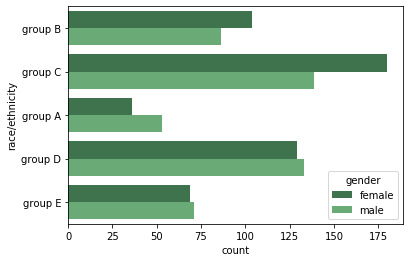

In [74]:
# Plot counts for each combination of levels.
sns.countplot(y="race/ethnicity", hue="gender", data=student_df, palette="Greens_d")
plt.show()

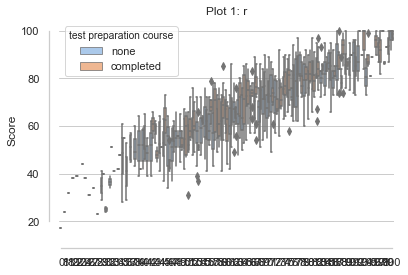

In [98]:
#Comparing groups again, but with a different emphasis.

# Setting the overall aesthetic.
sns.set(style="whitegrid")

student = student_df
ax = sns.boxplot(x='math score',y='reading score',hue='test preparation course',data=student,palette='pastel')  

plt.title('Plot 1: r')

sns.despine(offset=10, trim=True)
ax.set(xlabel='', ylabel='Score')

plt.show()

#### Note on Chi-Square: don't forget the differences we see above should be checked using formal statistical tests. For this purpose, we can use the Chi-squared test. It indicates whether one combination of variables is significantly different than the rest:

In [75]:
# Test will return a chi-square test statistic and a p-value. Like the t-test,
# the chi-square is compared against a distribution (the chi-square
# distribution) to determine whether the group size differences are large
# enough to reflect differences in the population.
print(stats.chisquare(count_table, axis=None))

Power_divergenceResult(statistic=181.70000000000002, pvalue=2.237210012745866e-34)


### Target Variable: The target variable should be located at the center of our exploratory data analysis.

In our case of the YouTube dataset, we are analyzing 'Video_views' for our purpose of PREDICTING the video views per channel.

That said, by no means are we claiming any multivariate analysis should include only the target variable. Knowing the relationships between the variables other than the target variable is also a useful insight. As we'll see in the next checkpoint, one objective of a data science project is to feed our model as few variables as possible while losing as little information as possible. Of course, this is a trade-off, and we strike the balance by detecting features that are least useful in the presence of the other features.

A note on the number of targets: Although in a majority of the data science projects we only have a single target, in some cases having multiple targets is also possible. 

## Feature Engineering: Transforming the existing variables
Transforming the existing variables is a very common need for numerous reasons. Among them, we limit our attention to the following:

Machine learning models can only work with numeric variables. So, categorical variables that have text values need to be converted to numeric values.
Some machine learning models assume the target variable to be normally distributed. In order to use these models, we may need to transform our target to be normally distributed.
Some machine learning models are very sensitive to the relative magnitude of values. So, we may need to limit the values of the variables to some fixed range. Usually, we do this by normalizing our variables.
To help our intuition and our understanding of the data, we may want to transform variables to a different unit of measurement.


### Working with categorical variables
Since most models require that all data be numeric, we need to convert our string based categorical data to use it. One method for this purpose is called one hot encoding. In one hot encoding, to get the information from a categorical variable with X levels, we create X-1 numeric features, each of which is coded 1 or 0. The resulting variables that take 0 or 1 for each category are known as dummy or indicator variables. To apply one hot encoding to a categorical variable, we can use the Pandas .get_dummies() function.

Consider the YouTube dataset. The variable Grade is categorical, taking the values A++, A+, A, A-, B+. While the Grade variable has 5 levels, only 4 features are needed to represent all of the information. Why 4? The reason being, if we know the values for A++, A+, A, and A- are 0, then we also know that the value for B+ must be 1. This level without a feature is called the reference value.

In [76]:
# one-hot encoding the Grade variable: 
pd.get_dummies(youtube_df["Grade"])

,A,A+,A++,A-,B+,
0,0,0,1,0,0,0
1,0,0,1,0,0,0
2,0,0,1,0,0,0
3,0,0,1,0,0,0
4,0,0,1,0,0,0
...,...,...,...,...,...,...
4995,0,0,0,0,1,0
4996,0,0,0,0,1,0
4997,0,0,0,0,1,0
4998,0,0,0,0,1,0


#### Observation: We have 5,000 records across the newly encoded columns/features.
**Exclude 1 of the variables from dummy-coding when we include them in a model for the reasons explained above.**

One might forget this point. So set the drop_first parameter of .get_dummies() to True. This will exclude the 1st category from dummy-coding.

Also,just calling pd.get_dummies(youtube_df["Grade"]) won't store the dummies in the data frame; you can append them to the data frame by using pd.concat(). 


* The axis = 1 parameter will concatenate the 2 DataFrames along the column. 

In [77]:
# append dummies to YouTube dataframe
youtube_df = pd.concat([youtube_df, pd.get_dummies(youtube_df["Grade"])], axis=1)
youtube_df

,Rank,Grade,Channel name,Video Uploads,Subscribers,Video views,views_group,winsorized_uploads,winsorized_subscribers,winsorized_views,A,A+,A++,A-,B+,
0,1st,A++,Zee TV,82757.0,18752952.0,20869786591,1,5653.0,5895361.0,2468241402,0,0,1,0,0,0
1,2nd,A++,T-Series,12661.0,61196304.0,47548839843,1,5653.0,5895361.0,2468241402,0,0,1,0,0,0
2,3rd,A++,Cocomelon - Nursery Rhymes,373.0,19238252.0,9793305082,1,373.0,5895361.0,2468241402,0,0,1,0,0,0
3,4th,A++,SET India,27323.0,31180560.0,22675948293,1,5653.0,5895361.0,2468241402,0,0,1,0,0,0
4,5th,A++,WWE,36756.0,32852346.0,26273668433,1,5653.0,5895361.0,2468241402,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,"4,996th",B+,Uras Benlioğlu,706.0,2072942.0,441202795,2,706.0,2072942.0,441202795,0,0,0,0,1,0
4996,"4,997th",B+,HI-TECH MUSIC LTD,797.0,1055091.0,377331722,2,797.0,1055091.0,377331722,0,0,0,0,1,0
4997,"4,998th",B+,Mastersaint,110.0,3265735.0,311758426,2,110.0,3265735.0,311758426,0,0,0,0,1,0
4998,"4,999th",B+,Bruce McIntosh,3475.0,32990.0,14563764,3,3475.0,32990.0,14563764,0,0,0,0,1,0


### Dealing with non normality:  **Box-Cox Transformation Alternative
Many machine learning models assume the target variable to be normally distributed. If normality is an assumption, then non normal variables can sometimes be transformed into normally distributed features using transformations such as taking the square root, the inverse, or the log of the variable; or by applying the **Box-Cox transformation**.

Above, we can statistically verify the distributions of the log transformed variables still don't follow the normal distribution by using the: **Jarque-Bera and Normal tests from scipy**:


In [78]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(np.log(youtube_df["Subscribers"]))
norm_stats = normaltest(np.log(youtube_df["Subscribers"]))

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(np.log(youtube_df["Video Uploads"]))
norm_stats = normaltest(np.log(youtube_df["Video Uploads"]))

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(np.log(youtube_df["Video views"]))
norm_stats = normaltest(np.log(youtube_df["Video views"]))

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 3650.18501143955 and p value is 0.0
Normality test statistics is 1168.7793574548339 and p value is 1.5950975481327862e-254
Jarque-Bera test statistics is 83.01330104290801 and p value is 0.0
Normality test statistics is 71.5114065304969 and p value is 2.9613884303178817e-16
Jarque-Bera test statistics is 7862.3171340522895 and p value is 0.0
Normality test statistics is 1180.823167194929 and p value is 3.8681846024387925e-257


#### NOTE The p-values are 0 which indicates that the distribution of the log transformed variables is statistically different from the normal distribution. 
However, these transformations might still be useful. In general, working with distributions that "look" normal (with 2 tails on the left and right and a clustering of values around the mean) is easier than working with 1 tailed distributions. Even still, some models only require multivariate normality which can be achieved more easily using these kinds of distributions. Hence, if we see that the distribution of a variable more closely resembles the normal distribution after a transformation, it could still be helpful even if it's not exactly normal.

Another common method to make variables normally distributed is the Box-Cox transformation. Applying this transformation is pretty easy using SciPy's boxcox() function from the stats module:

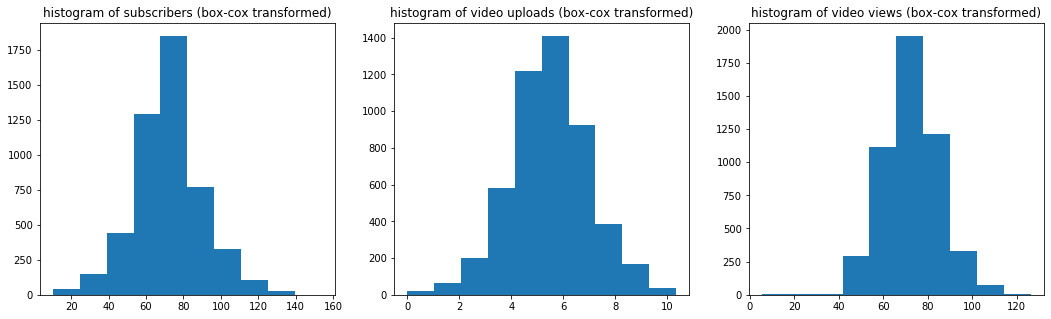

In [79]:
from scipy.stats import boxcox

video_uploads_boxcox,_ = boxcox(youtube_df["Video Uploads"])
subscribers_boxcox,_ = boxcox(youtube_df["Subscribers"])
video_views_boxcox,_ = boxcox(youtube_df["Video views"])

plt.figure(figsize=(18,5))

# histograms of the box-cox transformed data
plt.subplot(1, 3, 1)
plt.hist(subscribers_boxcox)
plt.title("histogram of subscribers (box-cox transformed)")

plt.subplot(1, 3, 2)
plt.hist(video_uploads_boxcox)
plt.title("histogram of video uploads (box-cox transformed)")

plt.subplot(1, 3, 3)
plt.hist(video_views_boxcox)
plt.title("histogram of video views (box-cox transformed)")

plt.show()

#### Note: The histograms above resemble the normal distribution quite well, although they are still not quite normally distributed. We can confirm this using the Jargue-Bera and Normal tests:

In [80]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(subscribers_boxcox)
norm_stats = normaltest(subscribers_boxcox)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(video_uploads_boxcox)
norm_stats = normaltest(video_uploads_boxcox)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(video_views_boxcox)
norm_stats = normaltest(video_views_boxcox)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 112.2691040776772 and p value is 0.0
Normality test statistics is 64.32778131642941 and p value is 1.0749784809968669e-14
Jarque-Bera test statistics is 32.0043564508529 and p value is 1.1229031449122573e-07
Normality test statistics is 23.235963338446687 and p value is 9.002739219409114e-06
Jarque-Bera test statistics is 93.4064021228951 and p value is 0.0
Normality test statistics is 55.77146119242227 and p value is 7.751416591883903e-13


#### Note that Box-Cox, log, and square root transformations only work when all datapoints are positive.

### Normalization and standardization
Some statistical techniques, such as **principal components analysis (PCA)** —which we'll see in the following checkpoint—and machine learning models assume that all features have values in the same range (e.g., a min of 0 and a max of 1) or they exhibit normal statistical properties. For some techniques, features that vary in range can result in incorrect estimates and results. To be able to apply these techniques and methods, we need to rescale our variables to fit a limited range, or standardize our variables to exhibit some regular statistical patterns.



**Normalization** is the rescaling of a variable into the [0,1] range (including 0 and 1). For this purpose, we'll use SKLearn's .normalize() method from the preprocessing module.

**Standardization** is the rescaling of a variable so its mean becomes 0 and its standard deviation becomes 1. Notice in the standardization we don't apply a maximum value for the variable. To apply standardization, we'll use SKLearn's .scale() method from the preprocessing module.


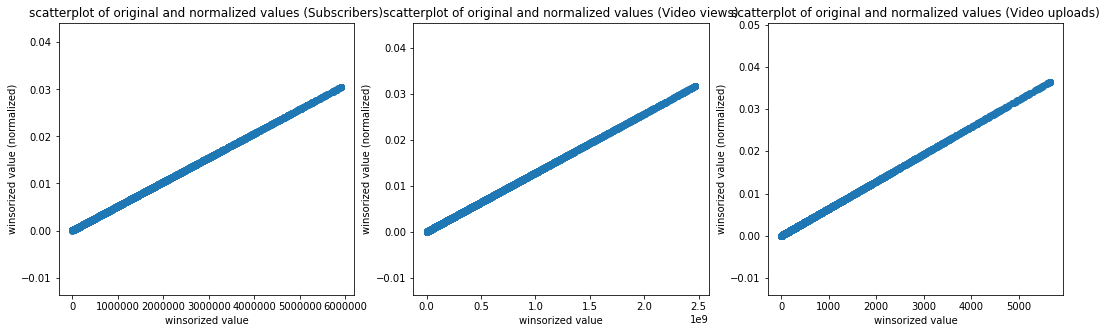

In [81]:
#Let's normalize the winsorized versions of the continuous variables in the YouTube dataset:
from sklearn.preprocessing import normalize

# normalize the winsorized variables
youtube_df["norm_winsorized_subscribers"] = normalize(np.array(youtube_df["winsorized_subscribers"]).reshape(1,-1)).reshape(-1,1)
youtube_df["norm_winsorized_views"] = normalize(np.array(youtube_df["winsorized_views"]).reshape(1,-1)).reshape(-1,1)
youtube_df["norm_winsorized_uploads"] = normalize(np.array(youtube_df["winsorized_uploads"]).reshape(1,-1)).reshape(-1,1)

plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
# draw the scatter plot using seaborn.
plt.scatter(youtube_df["winsorized_subscribers"], youtube_df["norm_winsorized_subscribers"])
plt.title("scatterplot of original and normalized values (Subscribers)")
plt.xlabel("winsorized value")
plt.ylabel("winsorized value (normalized)")

plt.subplot(1,3,2)
# draw the scatter plot using seaborn.
plt.scatter(youtube_df["winsorized_views"], youtube_df["norm_winsorized_views"])
plt.title("scatterplot of original and normalized values (Video views)")
plt.xlabel("winsorized value")
plt.ylabel("winsorized value (normalized)")

plt.subplot(1,3,3)
# draw the scatter plot using seaborn.
plt.scatter(youtube_df["winsorized_uploads"], youtube_df["norm_winsorized_uploads"])
plt.title("scatterplot of original and normalized values (Video uploads)")
plt.xlabel("winsorized value")
plt.ylabel("winsorized value (normalized)")

plt.show()


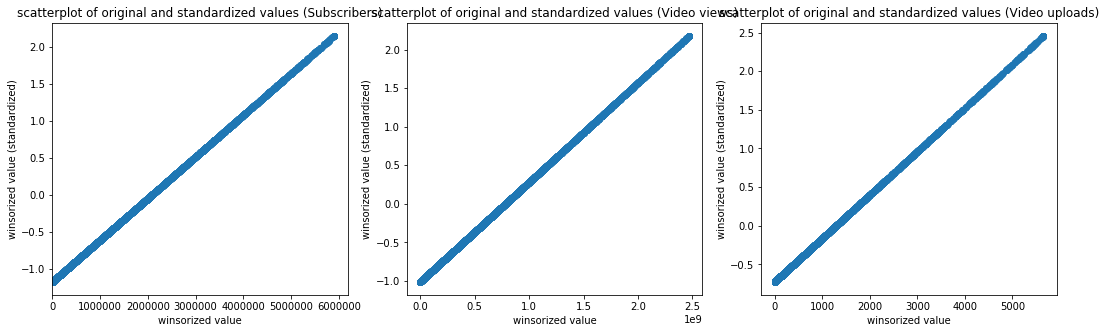

In [82]:
#Standardize the variable
from sklearn.preprocessing import scale

youtube_df["scaled_winsorized_subscribers"] = scale(youtube_df["winsorized_subscribers"])
youtube_df["scaled_winsorized_views"] = scale(youtube_df["winsorized_views"])
youtube_df["scaled_winsorized_uploads"] = scale(youtube_df["winsorized_uploads"])

plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
# draw the scatter plot using seaborn.
plt.scatter(youtube_df["winsorized_subscribers"], youtube_df["scaled_winsorized_subscribers"])
plt.title("scatterplot of original and standardized values (Subscribers)")
plt.xlabel("winsorized value")
plt.ylabel("winsorized value (standardized)")
plt.xlim(0.00000001)

plt.subplot(1,3,2)
# draw the scatter plot using seaborn.
plt.scatter(youtube_df["winsorized_views"], youtube_df["scaled_winsorized_views"])
plt.title("scatterplot of original and standardized values (Video views)")
plt.xlabel("winsorized value")
plt.ylabel("winsorized value (standardized)")

plt.subplot(1,3,3)
# draw the scatter plot using seaborn.
plt.scatter(youtube_df["winsorized_uploads"], youtube_df["scaled_winsorized_uploads"])
plt.title("scatterplot of original and standardized values (Video uploads)")
plt.xlabel("winsorized value")
plt.ylabel("winsorized value (standardized)")

plt.show()

## EDA: Feature Engineering -- Dealing with Curse of Dimensionality
### Create New Variables
**Combining 2 or more highly correlated variables**: Many models assume that features are correlated with the outcome but uncorrelated with each other. Two highly correlated variables can be averaged to create a feature, or one can be dropped. Three or more highly correlated variables can also be combined using a statistical method called **Principal Components Analysis (PCA)** that reduces the correlated set of variables into a smaller set of uncorrelated features. 

**Interactions of variables**: If you suspect the relationship between the outcome and a feature depends on the value of a 2nd feature, you may want to create a feature that represents the interaction between them. Say, for example, watching more TV only makes people sad if they do it alone. People who live with a partner are probably less likely to watch TV alone. To represent the concept that people who live with a romantic partner don't get sad watching TV but people who don't live with a romantic partner do get sad, we can multiply our 'partner' indicator by the 'sadness' feature to create the interaction.

**Creating linear relationships**: Many models assume that the relationship between a feature and an outcome is linear. However, at times you want to include a variable that has a nonlinear component to its relationship with the outcome. To capture nonlinearity while satisfying the model's assumptions, it can be helpful to create quadratic or higher level features by squaring, cubing, or otherwise multiplying a variable by itself.

#### Note: PCA works best for normally distributed data and assumes the relationships among variables are linear. PCA also works best when the variables involved range from weak to moderately strong correlations. Correlations of 0, or correlations greater than .7 or .8, create problems. Correlations near 0 mean there is no shared information. Correlations that are too high can result in components that are unstable and, therefore, change a lot in response to very small changes in the data or components made up of variance from only 1 or 2 variables. A few very high or very low correlations are fine. It is when we have a variable with mostly very high or very low correlations with other variables that problems can occur.

#### Note 2: Approaches in feature selection
**Feature selection** is like handing out roses on The Bachelor. We want to keep the features that have the strongest connection to the outcome, while also prioritizing features that bring something unique to the table. Unlike The Bachelor, our goal isn't to narrow the options down to only one ideal "featurette," but to settle on a set of features that is relatively straightforward to understand, is predictively powerful, minimizes overfitting, and is relatively computationally efficient. Feature selection is a balancing act between explanatory power and model parsimony. Fortunately, many feature selection algorithms are available to help data scientists optimize their feature sets.

#### Feature selection algorithms fall into 4 broad groups. 
Two of them are integrated with the modeling phase, which we will illustrate in later modules where we discuss machine learning algorithms. Instead, you can apply filter methods easily using the techniques we discussed previously in this module. We will also introduce a dimensionality reduction technique later in this checkpoint.

**Filter methods**
Filter methods evaluate each feature separately and assign it a "score" that's used to rank the features, with scores above a certain cutoff point being retained or discarded. The feature may be evaluated independently of the outcome, or in combination with it. Variance thresholds—where only features with a variance above a certain cutoff are retained—are an example of independently evaluating features. The correlation of each feature with the outcome can also be used as a filter method and we can do this by looking at the correlation table or the Pearson correlation matrix.

Filter methods are good at selecting relevant features likely related to the target. They are computationally simple and straightforward, but inclined to produce lists of redundant features since interfeature relationships are not considered. Because they're "cheap" to run, you might use filter methods as a 1st pass at reducing features before applying more computationally demanding algorithms like wrapper methods.

**Wrapper methods**
Wrapper methods select sets of features. Different sets are constructed and evaluated in terms of their predictive power in a model, and their performance is compared to the performance of other sets. Wrapper methods differ in terms of how the sets of features are constructed. Two such feature construction methods are forward passes and backward passes. In forward passes, the algorithm begins with no features and adds features 1-by-1, always adding the feature that results in the highest increase in predictive power and stopping at some predetermined threshold. In backward passes, the algorithm begins with all features and drops features 1-by-1, always dropping the feature with the least predictive power and stopping at some predetermined threshold. Forward and backward pass methods are considered "greedy" because once a feature is added (forward) or removed (backward) it's never again evaluated for the model.

Wrapper methods are good at selecting useful sets of features that effectively predict the outcome. For larger sets of features, however, wrapper methods can be computationally intensive.

**Embedded methods**
Embedded methods also select sets of features, but do so as an intrinsic part of the fitting method for the particular type of model you're using. This may involve regularization, where a "complexity penalty" is added to the fitness measures typically used to assess the predictive power of a model. Embedded methods provide the benefits of wrapper methods but are less computationally intensive. Different types of models will use different embedded methods.

**Dimensionality reduction methods**
Another common approach in feature selection is to use dimensionality reduction techniques. These methods are especially useful when we have a lot of features, and applying the techniques we mentioned above might be computationally very expensive. Among the several dimension reduction techniques, one is so popular that every data scientist should know it. It's called Principal Components Analysis (PCA) and we discuss it next.

In [83]:
## Side example
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'fifa19'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

fifa_df = pd.read_sql_query('select * from fifa19',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

fifa_df = fifa_df.iloc[:,53:87]
fifa_df.corr()

,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
Crossing,1.000000,0.655300,0.469507,0.809660,0.690339,0.856647,0.833105,0.761107,0.756527,0.840916,...,0.645805,0.575446,0.443101,0.428963,0.409961,-0.663053,-0.660193,-0.659767,-0.660160,-0.662539
Finishing,0.655300,1.000000,0.473427,0.661830,0.882675,0.824337,0.759229,0.697550,0.512806,0.788376,...,0.837827,0.533414,0.024218,-0.033023,-0.071811,-0.588752,-0.587145,-0.583268,-0.584852,-0.586913
HeadingAccuracy,0.469507,0.473427,1.000000,0.640091,0.505639,0.550750,0.440846,0.407772,0.510779,0.658175,...,0.551978,0.507208,0.583123,0.561063,0.533643,-0.750417,-0.749888,-0.746444,-0.744443,-0.748895
ShortPassing,0.809660,0.661830,0.640091,1.000000,0.698309,0.843722,0.775398,0.736659,0.895722,0.911451,...,0.676063,0.685137,0.559576,0.541131,0.508644,-0.729785,-0.728024,-0.724381,-0.723782,-0.728721
Volleys,0.690339,0.882675,0.505639,0.698309,1.000000,0.809639,0.807285,0.749637,0.571050,0.794935,...,0.829257,0.595281,0.120919,0.072788,0.035457,-0.590808,-0.588668,-0.584954,-0.586131,-0.588670
Dribbling,0.856647,0.824337,0.550750,0.843722,0.809639,1.000000,0.842652,0.753600,0.722465,0.938942,...,0.769594,0.597498,0.336072,0.301251,0.273963,-0.754625,-0.753181,-0.749816,-0.751348,-0.754341
Curve,0.833105,0.759229,0.440846,0.775398,0.807285,0.842652,1.000000,0.861277,0.710807,0.829568,...,0.751833,0.616532,0.289529,0.261481,0.232869,-0.606286,-0.603141,-0.600266,-0.603540,-0.604960
FKAccuracy,0.761107,0.697550,0.407772,0.736659,0.749637,0.753600,0.861277,1.000000,0.703544,0.759548,...,0.734440,0.585120,0.297976,0.279153,0.247903,-0.556605,-0.553644,-0.549911,-0.552641,-0.554920
LongPassing,0.756527,0.512806,0.510779,0.895722,0.571050,0.722465,0.710807,0.703544,1.000000,0.788650,...,0.542247,0.645797,0.587106,0.587430,0.562230,-0.596820,-0.594999,-0.591453,-0.591561,-0.595887
BallControl,0.840916,0.788376,0.658175,0.911451,0.794935,0.938942,0.829568,0.759548,0.788650,1.000000,...,0.769791,0.674881,0.452705,0.417566,0.384802,-0.788444,-0.786797,-0.783423,-0.783607,-0.787939


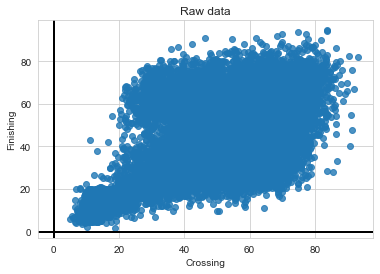

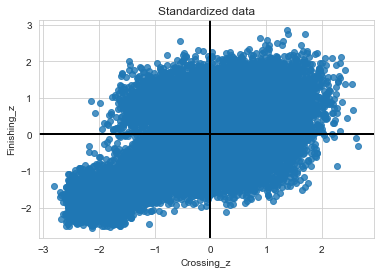

In [84]:
#Now, see how the role of rotation in PCA in a 2-D space using only the Crossing and Finishing variables:
t = sns.regplot(
    'Crossing',
    'Finishing',
    fifa_df,
    x_jitter=.49,
    y_jitter=.49,
    fit_reg=False
)
#t.set(xlim=(-1, 11), ylim=(-1, 11))
t.axhline(0, color='k', linestyle='-', linewidth=2)
t.axvline(0, color='k', linestyle='-', linewidth=2)
t.axes.set_title('Raw data')
plt.show()

# Standardizing variables by subtracting the mean and dividing by the standard
# deviation. Now both variables are on the same scale.
fifa_st_df = pd.DataFrame()
fifa_st_df['Crossing_z'] = (fifa_df['Crossing'] - fifa_df['Crossing'].mean()) / fifa_df['Crossing'].std()
fifa_st_df['Finishing_z'] = (fifa_df['Finishing'] - fifa_df['Finishing'].mean()) / fifa_df['Finishing'].std()

t = sns.regplot(
    'Crossing_z',
    'Finishing_z',
    fifa_st_df,
    x_jitter=.49,
    y_jitter=.49,
    fit_reg=False
)
t.axhline(0, color='k', linestyle='-', linewidth=2)
t.axvline(0, color='k', linestyle='-', linewidth=2)
t.axes.set_title('Standardized data')
plt.show()



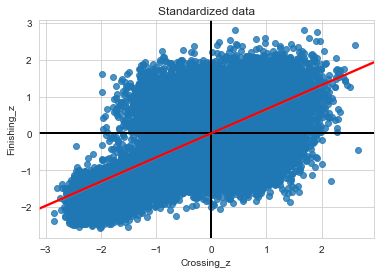

In [85]:
t = sns.regplot(
    'Crossing_z',
    'Finishing_z',
    fifa_st_df,
    x_jitter=.49,
    y_jitter=.49,
    fit_reg=False
)
t.axhline(0, color='k', linestyle='-', linewidth=2)
t.axvline(0, color='k', linestyle='-', linewidth=2)
t.axes.set_title('Standardized data')

sns.regplot('Crossing_z', 
            'Finishing_z', 
            fifa_st_df, 
            scatter=False, 
            color="red")

plt.show()

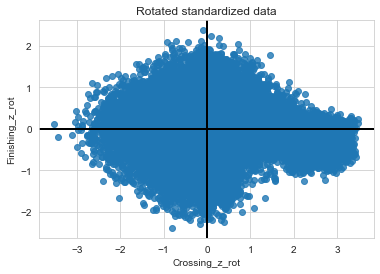

In [87]:
# Rotating the data so that the axes roughly match to vector above.
import math

fifa_st_df['Crossing_z_rot'] = math.cos(40) * fifa_st_df['Crossing_z'] - math.sin(40) * fifa_st_df['Finishing_z']
fifa_st_df['Finishing_z_rot'] = math.sin(40) * fifa_st_df['Crossing_z'] + math.cos(40) * fifa_st_df['Finishing_z']

t = sns.regplot(
    'Crossing_z_rot',
    'Finishing_z_rot',
    fifa_st_df,
    x_jitter=.49,
    y_jitter=.49,
    fit_reg=False
)
t.axhline(0, color='k', linestyle='-', linewidth=2)
t.axvline(0, color='k', linestyle='-', linewidth=2)
t.axes.set_title('Rotated standardized data')
plt.show()


In [89]:
# from matplotlib.mlab import PCA as mlabPCA # deprecated
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

fifa_df = fifa_df.dropna()
# Normalize the data so that all variables have a mean of 0 and standard deviation
# of 1.
X = StandardScaler().fit_transform(fifa_df)

# The NumPy covariance function assumes that variables are represented by rows,
# not columns, so we transpose X.
Xt = X.T
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)

Covariance Matrix:
 [[ 1.00005507  0.65533573  0.46953243 ... -0.65980319 -0.6601961
  -0.66257575]
 [ 0.65533573  1.00005507  0.4734528  ... -0.58330031 -0.5848846
  -0.5869451 ]
 [ 0.46953243  0.4734528   1.00005507 ... -0.74648538 -0.74448373
  -0.74893673]
 ...
 [-0.65980319 -0.58330031 -0.74648538 ...  1.00005507  0.96438954
   0.96639022]
 [-0.6601961  -0.5848846  -0.74448373 ...  0.96438954  1.00005507
   0.97018302]
 [-0.66257575 -0.5869451  -0.74893673 ...  0.96639022  0.97018302
   1.00005507]]


In [90]:
# Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)

Eigenvector 1: 
[ 0.20031595  0.17960135  0.16494839  0.21087143  0.18542573  0.21397064
  0.19617801  0.18312402  0.186724    0.22044379  0.16424625  0.1624329
  0.16678123  0.09792308  0.14590308  0.19692239  0.06061726  0.18570425
  0.02849067  0.19595275  0.14657334  0.11695874  0.20068377  0.16230508
  0.18109287  0.15539206  0.12426471  0.11747611  0.11021307 -0.19648369
 -0.19617625 -0.1953696  -0.1954223  -0.19629495]
Eigenvalue 1: 18.84914420167135
----------------------------------------
Eigenvector 2: 
[-0.04188421 -0.22162393  0.17520018  0.03223146 -0.17866954 -0.10445267
 -0.12066113 -0.09891488  0.06745204 -0.03766039 -0.1279576  -0.10640897
 -0.1632028   0.01563515 -0.13947955 -0.08463877  0.11637021  0.10149888
  0.23049983 -0.14678066  0.25950774  0.34905342 -0.1528266  -0.15114339
 -0.14906097  0.00878257  0.33567009  0.35914161  0.36205102 -0.0824759
 -0.08304541 -0.08346555 -0.08147188 -0.08256632]
Eigenvalue 2: 4.910824565403956
-----------------------------------

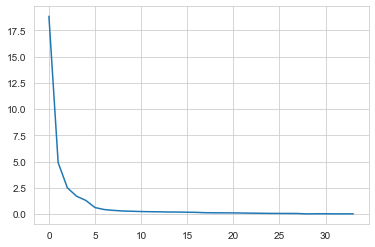

[18.8491442   4.91082457  2.51121968  1.70665278  1.30927179  0.62753979
  0.43931226  0.35950551  0.30147802  0.27677676  0.24896514  0.23252326
  0.22333056  0.20544558  0.20035624  0.18330501  0.17019445  0.13863386
  0.12832669  0.1245334   0.11821725  0.1076127   0.09255947  0.0833471
  0.07218427  0.06826828  0.06511574  0.0613974   0.02293761  0.03729554
  0.03753585  0.02663417  0.03038518  0.03104236]


In [91]:
# print scree plot
plt.plot(eig_val_cov)
plt.show()

print(eig_val_cov)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.55435606 0.14442806 0.07385533 0.05019291 0.03850587]


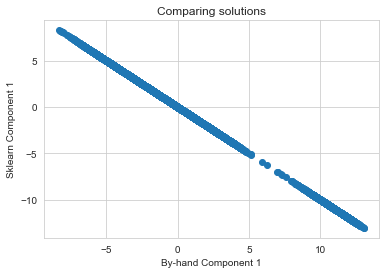

In [92]:
#Ultimately we have a solution that encompasses over 86% of the data's variance in just 5 components, rather than 34 variables.

#While we stepped through PCA by hand for learning purposes, there are PCA functions in both matplotlib and scikit-learn

sklearn_pca = PCA(n_components=5)
Y_sklearn = sklearn_pca.fit_transform(X)

P = eig_vec_cov[:, 0]

# Transform X into Y.
Y = P.T.dot(Xt)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

# Compare the sklearn solution to ours – a perfect match.
plt.plot(Y_sklearn[:, 0], Y, 'o')
plt.title('Comparing solutions')
plt.ylabel('Sklearn Component 1')
plt.xlabel('By-hand Component 1')
plt.show()

## PCA Lesson Learned:
Summary
PCA is a series of linear transformations applied to a data frame to yield a smaller number of columns that explain a large proportion of the total variance contained in a data frame. PCA works by 1st transforming the data  𝑋  into a covariance matrix  𝐶𝑋 . Then a set of eigenvectors  𝑃  is calculated that, when combined with  𝐶𝑋  through multiplication ( 𝑃𝐶𝑋𝑃𝑇 ), creates a new covariance matrix  𝐶𝑌  with 0s on the off diagonal elements. We then take  𝑃 , choose the eigenvectors corresponding to the most variance explained ( 𝑃𝑣𝑎𝑟 ), and use it to transform the original data  𝑋  (via  𝑃𝑣𝑎𝑟𝑋 ) into  𝑌 , a new simplified dataset with as many columns as eigenvector